In [1]:
# lib
# ! pip install albumentations
! pip install einops
! pip install timm

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import torch.utils.checkpoint as checkpoint

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.1 MB/s eta 0:00:00


In [2]:
# load
class AbdomenCT(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir):
        self.transform = A.Compose([
            A.Resize(512, 512),  # original(3,512,512)
            A.HorizontalFlip(),  # x-axis
            A.VerticalFlip(),  # y-axis
            A.RandomRotate90(p=0.1),  # rotation
            # A.ElasticTransform(p=0.1),
            A.Normalize(),  # normalization
            ToTensorV2(),
        ])
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.ids]
        
    def __getitem__(self, i):
        # read data
        image = np.array(Image.open(self.images_fps[i]).convert('RGB'))
        mask = np.array(Image.open(self.masks_fps[i]).convert('RGB'))
        image = self.transform(image=image, mask=mask)
        return image['image'], image['mask'][:,:,0]
    
    def __len__(self):
        return len(self.ids)

image_dir = os.path.join('/kaggle/input/abdomenct/image')
mask_dir = os.path.join('/kaggle/input/abdomenct/mask')

dataset = AbdomenCT(image_dir, mask_dir)
trainset, validset = random_split(dataset, [450, 50])

train_loader = DataLoader(dataset=trainset, batch_size=4, shuffle=True)
valid_loader = DataLoader(dataset=validset, batch_size=4, shuffle=True)
# (org)image_size: torch.Size([5, 3, 256, 256]), mask_size: torch.Size([5, 256, 256])

In [3]:
class BasicBlock(nn.Module):
    expansion: int = 4
    def __init__(self, inplanes, planes, stride = 1, downsample = None, groups = 1,
        base_width = 64, dilation = 1, norm_layer = None):
        
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = nn.Conv2d(inplanes, planes ,kernel_size=3, stride=stride, 
                               padding=dilation,groups=groups, bias=False,dilation=dilation)
        
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes ,kernel_size=3, stride=stride, 
                               padding=dilation,groups=groups, bias=False,dilation=dilation)
        
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample= None,
        groups = 1, base_width = 64, dilation = 1, norm_layer = None,):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, stride=1, bias=False)
        self.bn1 = norm_layer(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride, bias=False, padding=dilation, dilation=dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = nn.Conv2d(width, planes * self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(
        self,block, layers,num_classes = 1000, zero_init_residual = False, groups = 1,
        width_per_group = 64, replace_stride_with_dilation = None, norm_layer = None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 2
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
            
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64//4, layers[0], stride=2)
        self.layer2 = self._make_layer(block, 128//4, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256//4, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512//4, layers[3], stride=1, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block,
        planes,
        blocks,
        stride = 1,
        dilate = False,
    ):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = stride
            
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes,  planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                norm_layer(planes * block.expansion))

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )
        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        out = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        out.append(x)
        x = self.layer2(x)
        out.append(x)
        x = self.layer3(x)
        out.append(x)
        # 最后一层不输出
        # x = self.layer4(x)
        # out.append(x)
        return out

    def forward(self, x) :
        return self._forward_impl(x)

    def _resnet(block, layers, pretrained_path = None, **kwargs,):
        model = ResNet(block, layers, **kwargs)
        if pretrained_path is not None:
            model.load_state_dict(torch.load(pretrained_path),  strict=False)
        return model
    
    def resnet50(pretrained_path=None, **kwargs):
        return ResNet._resnet(Bottleneck, [3, 4, 6, 3], pretrained_path,**kwargs)
    
    def resnet101(pretrained_path=None, **kwargs):
        return ResNet._resnet(Bottleneck, [3, 4, 23, 3], pretrained_path,**kwargs)

if __name__ == "__main__":
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    v = ResNet.resnet50().to(device)
    img = torch.randn(1, 3, 512, 512).cuda()
    preds = v(img)

    
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, dim, depth, heads, mlp_dim, channels = 512, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.out = Rearrange("b (h w) c->b c h w", h=image_height//patch_height, w=image_width//patch_width)
        
        # 这里上采样倍数为8倍。为了保持和图中的feature size一样
        self.upsample = nn.UpsamplingBilinear2d(scale_factor = patch_size//2)
        self.conv = nn.Sequential(
            nn.Conv2d(dim, dim, 3, padding=1),
            nn.BatchNorm2d(dim),
            nn.ReLU())

    def forward(self, img):
        # 这里对应了图中的Linear Projection，主要是将图片分块嵌入，成为一个序列
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        # 为图像切片序列加上索引
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        # 输入到Transformer中处理
        x = self.transformer(x)

        # delete cls_tokens, 输出前需要删除掉索引
        output = x[:,1:,:]
        output = self.out(output)

        # Transformer输出后，上采样到原始尺寸
        output = self.upsample(output)
        output = self.conv(output)

        return output

if __name__ == "__main__":
    v = ViT(image_size = (64, 64), patch_size = 16, channels = 256, dim = 512, depth = 12, heads = 16, mlp_dim = 1024, dropout = 0.1, emb_dropout = 0.1).cpu()
    # 假设ResNet50第三层输出大小是 1, 256, 64, 64 也就是b, c, W/8, H/8
    img = torch.randn(1, 256, 64, 64).cpu()
    preds = v(img)
    # 输出是 b, c, W/16, H/16
    # preds:  torch.Size([1, 512, 32, 32])

In [4]:
class TransUnetEncoder(nn.Module):
    def __init__(self, **kwargs):
        super(TransUnetEncoder, self).__init__()
        self.R50 = ResNet.resnet50()
        self.Vit = ViT(image_size = (64, 64), patch_size = 16, channels = 256, dim = 512, depth = 12, heads = 16, mlp_dim = 1024, dropout = 0.1, emb_dropout = 0.1)

    def forward(self, x):
        x1, x2, x3 = self.R50(x)
        x4 = self.Vit(x3)
        return [x1, x2, x3, x4]

if __name__ == "__main__":
    x = torch.randn(1, 3, 512, 512).cuda()
    net = TransUnetEncoder().cuda()
    out = net(x)

    
class TransUnetDecoder(nn.Module):
    def __init__(self, out_channels=64, **kwargs):
        super(TransUnetDecoder, self).__init__()
        self.decoder1 = nn.Sequential(
            nn.Conv2d(out_channels//4, out_channels//4, 3, padding=1), 
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU()            
        )
        self.upsample1 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(out_channels, out_channels//4, 3, padding=1),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU()     
        )

        self.decoder2 = nn.Sequential(
            nn.Conv2d(out_channels*2, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()            
        )
        self.upsample2 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(out_channels*2, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()     
        )

        self.decoder3 = nn.Sequential(
            nn.Conv2d(out_channels*4, out_channels*2, 3, padding=1),
            nn.BatchNorm2d(out_channels*2),
            nn.ReLU()            
        )        
        self.upsample3 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(out_channels*4, out_channels*2, 3, padding=1),
            nn.BatchNorm2d(out_channels*2),
            nn.ReLU()     
        )

        self.decoder4 = nn.Sequential(
            nn.Conv2d(out_channels*8, out_channels*4, 3, padding=1),
            nn.BatchNorm2d(out_channels*4),
            nn.ReLU()                           
        )
        self.upsample4 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(out_channels*8, out_channels*4, 3, padding=1),
            nn.BatchNorm2d(out_channels*4),
            nn.ReLU()     
        )

    def forward(self, inputs):
        x1, x2, x3, x4 = inputs
        # b 512 H/8 W/8
        
        x4 = self.upsample4(x4)
        x = self.decoder4(torch.cat([x4, x3], dim=1))        
        
        x = self.upsample3(x)
        x = self.decoder3(torch.cat([x, x2], dim=1))

        x = self.upsample2(x)
        x = self.decoder2(torch.cat([x, x1], dim=1))

        x = self.upsample1(x)
        x = self.decoder1(x)

        return x

if __name__ == "__main__":
    x1 = torch.randn([1, 64, 256, 256]).cuda()
    x2 = torch.randn([1, 128, 128, 128]).cuda()
    x3 = torch.randn([1, 256, 64, 64]).cuda()
    x4 = torch.randn([1, 512, 32, 32]).cuda()
    net = TransUnetDecoder().cuda()
    out = net([x1,x2,x3,x4])

class TransUnet(nn.Module):
    # 主要是修改num_classes 
    def __init__(self, num_classes=1, **kwargs):
        super(TransUnet, self).__init__()
        self.TransUnetEncoder = TransUnetEncoder()
        self.TransUnetDecoder = TransUnetDecoder()
        self.cls_head = nn.Sequential(nn.Conv2d(16, num_classes, 1),
                                      nn.Sigmoid(),
                                     )
    def forward(self, x):
        x = self.TransUnetEncoder(x)
        x = self.TransUnetDecoder(x)
        x = self.cls_head(x)
        return x
    
if __name__ == "__main__":
    # 输入的图像尺寸 [1, 3, 512, 512]
    x1 = torch.randn([1, 3, 512, 512]).cuda()
    net = TransUnet().cuda()
    out = net(x1)

In [5]:
# loss
class DiceBCELoss(nn.Module):
    # without loss descend
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        # BCEWithLogitsLoss: sigmoid+BCELoss
        self.bce = nn.BCELoss()
        
    def forward(self, inputs, targets, smooth=1):
        targets = torch.sigmoid(targets)
        # flatten label and prediction
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs*targets).sum()
        union = inputs.sum() + (targets.sum())
        dice_loss = 1 - ((2*intersection+smooth)/(union+smooth))
        bce_loss = self.bce(inputs, targets)
        loss = dice_loss*0.3 + bce_loss*0.7
        return loss

class IoU(nn.Module):
    def __init__(self):
        super(IoU, self).__init__()
        
    def forward(self, inputs, targets, smooth=0.1, threshold=0.3):
        # flatten label and prediction
        targets = torch.sigmoid(targets)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        tempinputs = inputs.detach().cpu()
        temptargets = targets.detach().cpu()
        
        temptargets[np.nonzero(temptargets<=threshold)] = 0.0
        temptargets[np.nonzero(temptargets>threshold)] = 1.0
        # print(tempinputs, temptargets)
        intersection = (tempinputs*temptargets).sum()
        union = tempinputs.sum() + temptargets.sum()
        iou = (intersection+smooth)/(union-intersection+smooth)
        # print(intersection, union, iou)
        return iou

In [6]:
# train, test
def trainer(model, train_loader, valid_loader, criterion, optimizer, iou, epochs):
    
    loss_hist, train_hist, valid_hist = [],[],[]
    best_acc = 0
    for epoch in range(epochs):
        print('epoch{}/{}'.format(epoch+1, epochs))
        # model.train()
        losses, train_iou, valid_iou = [],[],[]
        for image, mask in train_loader:
            image = image.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            pred = model.forward(image)
            
            trainpiou = iou(pred,mask)
            loss = criterion(pred, mask)
            
            losses.append(loss.item())
            train_iou.append(trainpiou.detach().cpu())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # model.eval()
        with torch.no_grad():
            for image, mask in valid_loader:
                image = image.to(device)
                mask = mask.to(device)
                pred = model.forward(image)
                validpiou = iou(pred, mask)
                
            valid_iou.append(validpiou.detach().cpu())
            if epoch == (epochs-1):
                img = image.detach().cpu()
                msk = mask.detach().cpu()
                prd = pred.detach().cpu()
                
                prd = torch.squeeze(prd)
                prd_size = prd.shape
                prd = prd.view(-1)
                prd[np.nonzero(prd<=0.7)] = 0.0
                prd[np.nonzero(prd>0.7)] = 1.0
                prd = prd.reshape(prd_size)
        
        loss_hist.append(np.mean(losses))
        train_hist.append(np.mean(train_iou))
        valid_hist.append(np.mean(valid_iou))
        print('loss:{}'.format(loss_hist[-1]))
        print('Train Accuracy:{}'.format(train_hist[-1]))
        print('Validation Accuracy:{}'.format(valid_hist[-1]))
        
        if valid_hist[-1] > best_acc:
            print(f'Best model found at epoch {epoch+1}, saving model')
            torch.save(model.state_dict(), 'AbdomenCT_unet.pt')
            best_acc = valid_hist[-1]
        
    return loss_hist, train_hist, valid_hist, img, msk, prd


def plot_model_hist(train_hist, valid_hist, loss_hist):
    x = np.arange(len(train_hist))
    
    fig = plt.figure(figsize=(10,6))
    plt.plot(x, train_hist, label='train_dice')
    plt.plot(x, valid_hist, label='valid_dice')
    plt.plot(x, loss_hist, label='train_loss')
    
    plt.title('transunet', fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel('Epoch')
    plt.ylabel('IoU/Loss')
    
    plt.show()

epoch1/100
loss:0.5809534666812526
Train Accuracy:0.5807713270187378
Validation Accuracy:0.5838660597801208
Best model found at epoch 1, saving model
epoch2/100
loss:0.5638487708252088
Train Accuracy:0.6035609841346741
Validation Accuracy:0.6003671288490295
Best model found at epoch 2, saving model
epoch3/100
loss:0.557880593084656
Train Accuracy:0.6025341153144836
Validation Accuracy:0.5923929214477539
epoch4/100
loss:0.5543388608282647
Train Accuracy:0.6031798124313354
Validation Accuracy:0.6006438136100769
Best model found at epoch 4, saving model
epoch5/100
loss:0.5551036643770944
Train Accuracy:0.6034258008003235
Validation Accuracy:0.5910016894340515
epoch6/100
loss:0.5530956756752149
Train Accuracy:0.6026338338851929
Validation Accuracy:0.5943768620491028
epoch7/100
loss:0.5514817396096424
Train Accuracy:0.6026742458343506
Validation Accuracy:0.6175785064697266
Best model found at epoch 7, saving model
epoch8/100
loss:0.5518872569092607
Train Accuracy:0.6028809547424316
Validati

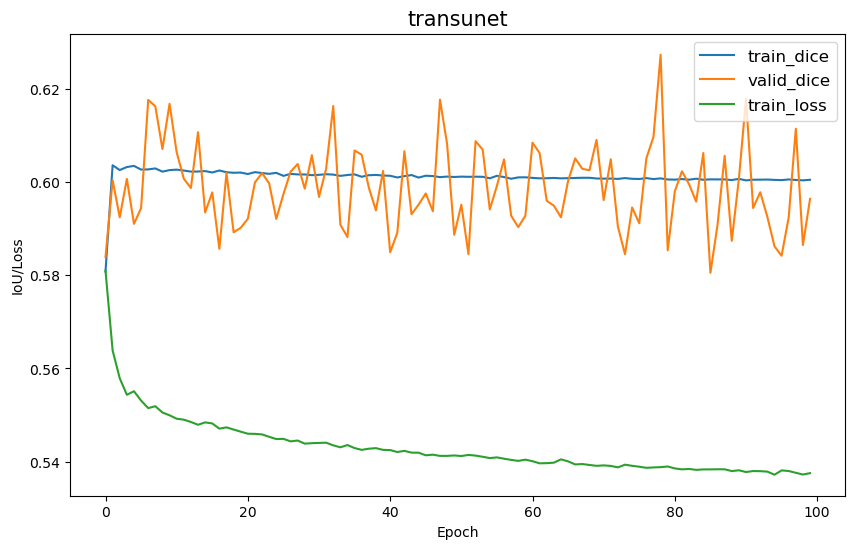

In [7]:
# run
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TransUnet().to(device)
criterion = DiceBCELoss()
iou = IoU()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epochs = 100

loss_hist, train_hist, valid_hist, img1, msk1, prd1 = trainer(model, train_loader, valid_loader, criterion, optimizer, iou, epochs)
plot_model_hist(train_hist, valid_hist, loss_hist)

torch.Size([2, 3, 512, 512])
torch.Size([2, 512, 512])
torch.Size([2, 512, 512])
tensor([[[-2.0494, -2.0494, -2.0494,  ..., -2.0494, -2.0665, -2.0837],
         [-2.0665, -2.0665, -2.0494,  ..., -2.0837, -2.0665, -2.0665],
         [-2.0665, -2.0665, -2.0665,  ..., -2.0837, -2.0665, -2.0323],
         ...,
         [-2.0837, -2.0837, -2.0665,  ..., -1.3815, -1.9467, -2.1008],
         [-2.0837, -2.0665, -2.0494,  ..., -1.6384, -2.0665, -2.1179],
         [-2.0665, -2.0494, -2.0665,  ..., -1.8439, -2.1179, -2.1179]],

        [[-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9832, -2.0007],
         [-1.9832, -1.9832, -1.9657,  ..., -2.0007, -1.9832, -1.9832],
         [-1.9832, -1.9832, -1.9832,  ..., -2.0007, -1.9832, -1.9482],
         ...,
         [-2.0007, -2.0007, -1.9832,  ..., -1.2829, -1.8606, -2.0182],
         [-2.0007, -1.9832, -1.9657,  ..., -1.5455, -1.9832, -2.0357],
         [-1.9832, -1.9657, -1.9832,  ..., -1.7556, -2.0357, -2.0357]],

        [[-1.7347, -1.7347, -1.7347

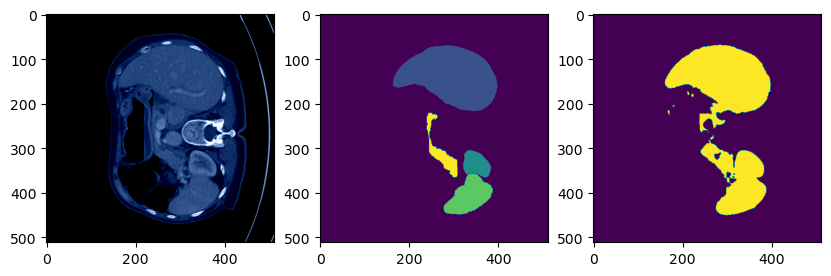

In [8]:
print(img1.shape)
print(msk1.shape)
print(prd1.shape)
print(img1[0,:,:,:])
print(msk1[0,:,:])
print(prd1[0,:,:])

plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow((img1[0,:,:,:].moveaxis(0,2)))
plt.subplot(132)
plt.imshow(msk1[0,:,:])
plt.subplot(133)
plt.imshow(prd1[0,:,:])

plt.show()